**Trabajo Final de Aprendizaje Automático.
Alumno: Leandro Vives.
Carrera de Doctorado en Ciencias Aplicadas y de la Ingeniería.**

El trabajo que aquí se plantea es un problema de clasificación binaria basado en la antropometría del deporte, es decir, la idea de que hay deportistas cuyas medidas corporales los hacen más aptos para determinados deportes. De acuerdo a esto y tomando como base de datos el peso y la altura de deportistas que participaron en los juegos olímpicos de Londres de 2012, se busca entrenar un clasificador que pueda discriminar a qué deporte podría pertenecer. Se realiza una clasificación entre dos deportes distintos como ser el Hockey y el Vóley, ya que se han analizado en primera instancia dos deportes con medidas antropométricas similares como el Vóley y el Básquet y resulta muy difícil la clasificación a partir de estas dos medidas solamente. Esta variabilidad se debe a las distintas posiciones y funciones dentro del juego, lo que a veces lleva a desviaciones grandes.

Los datos fueron obtenidos del siguiente link:
 https://docs.google.com/spreadsheets/d/1Y4xQqDuOVbn4mkEFUhW_xE5bgAy51raR1vlNZeXyl3Y/edit#gid=0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from matplotlib.colors import ListedColormap
%matplotlib inline


DEFAULT_AXIS=[-0.2, 1.5, -0.3, 1.3]

def plot_dataset(X, y, axes=DEFAULT_AXIS):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def plot_predictions(clf, axes=DEFAULT_AXIS, plot_sv=False, plot_cont=True):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    if plot_cont:
        plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    if plot_sv:
        try:
            svs = clf[:-1].inverse_transform(clf.steps[-1][1].support_vectors_)
            plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
        except:
            print("LinearSVC no guarda los Support Vectors, para eso us SVC con kernel='linear'")
      
def plot_decision_boundary(clf, X, y, axes=DEFAULT_AXIS, alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Realizo la lectura de los datos de un archivo .csv que posee la edad, altura (en cm) y peso (en kg) de distintos deportistas hombres y mujeres de Vóley y Hockey. Los deportistas estaban mezclados por deportes aleatoriamente, por lo que no hizo falta tener que hacer una mezcla en el procesado de datos.

In [3]:
# Leo los datos
df1 = pd.read_csv('Hockey_Volley.csv',sep=';', header=0)
df1.head()

,Age_M,Height_M,Weight_M,Sport_M,Age_F,Height_F,Weight_F,Sport_F
0,27,184,75,Hockey,26,171,60,Volleyball
1,31,171,71,Hockey,17,175,60,Volleyball
2,29,200,96,Volleyball,33,171,61,Hockey
3,26,194,88,Volleyball,23,184,80,Volleyball
4,31,201,86,Volleyball,24,191,79,Volleyball


Denomino ambos deportes con los siguientes labels: Hockey = 1 y Volleyball = 0.


In [4]:
# Convierto el frame de pandas a un np.array
sport_1=df1.to_numpy()
print(sport_1[:10,:])

[[27 184 75 'Hockey' 26 171 60 'Volleyball']
 [31 171 71 'Hockey' 17 175 60 'Volleyball']
 [29 200 96 'Volleyball' 33 171 61 'Hockey']
 [26 194 88 'Volleyball' 23 184 80 'Volleyball']
 [31 201 86 'Volleyball' 24 191 79 'Volleyball']
 [34 183 78 'Hockey' 27 155 51 'Hockey']
 [25 208 93 'Volleyball' 28 186 80 'Volleyball']
 [31 200 97 'Volleyball' 20 192 68 'Volleyball']
 [29 203 106 'Volleyball' 27 185 72 'Volleyball']
 [31 186 78 'Hockey' 25 164 60 'Hockey']]


In [5]:
for i in range(0, len(sport_1[:,3])):
  if sport_1[i,3] == 'Hockey':
    sport_1[i,3] = 1
  else:
      sport_1[i,3] = 0


In [6]:
for i in range(0, len(sport_1[:,7])):
  if sport_1[i,7] == 'Hockey':
    sport_1[i,7] = 1
  else:
      sport_1[i,7] = 0


Se observa que los labels están bien asignados en cada caso.

In [7]:
print(sport_1[:10,:])

[[27 184 75 1 26 171 60 0]
 [31 171 71 1 17 175 60 0]
 [29 200 96 0 33 171 61 1]
 [26 194 88 0 23 184 80 0]
 [31 201 86 0 24 191 79 0]
 [34 183 78 1 27 155 51 1]
 [25 208 93 0 28 186 80 0]
 [31 200 97 0 20 192 68 0]
 [29 203 106 0 27 185 72 0]
 [31 186 78 1 25 164 60 1]]


Separo en grupos de hombres y mujeres, ya que las medidas antropométricas son distintas y podrían llevar a errores. Además elimino el dato de la edad ya que no tiene relación en este caso con el label que se quiere predecir. 

In [8]:
sport_1_M = sport_1[:,1:4]
sport_1_F = sport_1[:,5:8]
print(sport_1_M.shape,sport_1_F.shape)

(305, 3) (305, 3)


In [9]:
df_M = pd.DataFrame(sport_1_M)
df_M.columns = ['Height_M','Weight_M','Sport_M']
df_M.head()

,Height_M,Weight_M,Sport_M
0,184,75,1
1,171,71,1
2,200,96,0
3,194,88,0
4,201,86,0


In [10]:
df_F = pd.DataFrame(sport_1_F)
df_F.columns = ['Height_F','Weight_F','Sport_F']
df_F.head()

,Height_F,Weight_F,Sport_F
0,171,60,0
1,175,60,0
2,171,61,1
3,184,80,0
4,191,79,0


In [11]:
XM_1=sport_1_M[:,:2]
yM_1=sport_1_M[:,2]
XF_1=sport_1_F[:,:2]
yF_1=sport_1_F[:,2]

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Divido cada grupo en sets de train y test.

In [14]:
XM1_train, XM1_test, yM1_train, yM1_test = train_test_split(XM_1, yM_1, test_size=0.3, random_state=42)
XF1_train, XF1_test, yF1_train, yF1_test = train_test_split(XF_1, yF_1, test_size=0.3, random_state=42)

In [15]:
print(yM1_train.shape,yM1_test.shape)

(213,) (92,)


Defino el tipo de número dentro de 'y' porque si no no funciona el entrenamiento.

In [16]:
yM1_train=yM1_train.astype('int')
yM1_test=yM1_test.astype('int')
yF1_train=yF1_train.astype('int')
yF1_test=yF1_test.astype('int') 

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from scipy.stats import reciprocal,uniform

Hago un escalado de los datos.

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
XM_train_1 = scaler.fit_transform(XM1_train)
XM_test_1 = scaler.transform(XM1_test)
XF_train_1 = scaler.fit_transform(XF1_train)
XF_test_1 = scaler.transform(XF1_test)

In [19]:
print(XM_train_1.shape, yM1_train.shape)

(213, 2) (213,)


In [20]:
print(np.min(XM_train_1[:,0]),np.max(XM_train_1[:,0]))
print(np.min(XM_train_1[:,1]),np.max(XM_train_1[:,1]))
print(np.min(XF_train_1[:,0]),np.max(XF_train_1[:,0]))
print(np.min(XF_train_1[:,1]),np.max(XF_train_1[:,1]))

-3.0822569827372077 2.3983642866553567
-3.238322869387113 3.230730084230284
-1.9505370058990552 2.879320960347155
-1.7146134931379786 3.960988873674831


Defino los límites en los ejes para cada sexo.

In [21]:
Axis_M= [-3.5, 3, -3.5, 3.5]
Axis_F= [-2, 3, -2, 4]

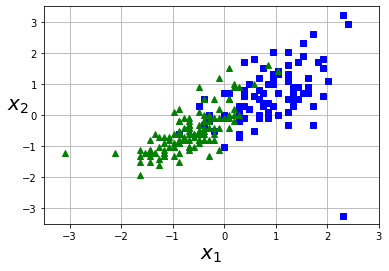

In [22]:
plot_dataset(XM_train_1, yM1_train, axes=Axis_M)

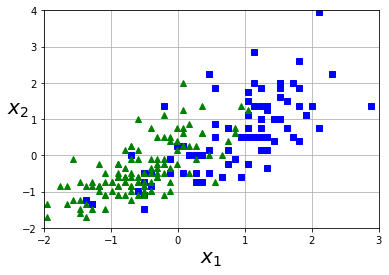

In [23]:
plot_dataset(XF_train_1, yF1_train, axes=Axis_F)

En el caso de las mujeres se observa que están menos diferenciados los deportes.

Entreno dos clasificadores en ambos grupos y analizo cuál es el mejor. Elijo un regresor logístico y un Support vector machine.

In [24]:
#1 Logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'saga', max_iter=200, random_state=42)
              
parametros_lr = {
    'penalty':['l2', 'l1'],
    'C': uniform(1,10)} 

In [25]:
#Support vector machine
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal,uniform

SVM = svm.SVC(kernel = 'rbf', random_state= 3, probability=True)

parametros_svm = {
    "C": uniform(1,5),
    "gamma": reciprocal(0.1,0.2)}

**Entrenamiento para los datos de los hombres.**

In [26]:
lrM_clf = RandomizedSearchCV(lr, parametros_lr, scoring= 'accuracy', cv=5, random_state=3) 
search_lrM = lrM_clf.fit(XM_train_1, yM1_train)
print('The parameters combination that would give best accuracy is : ')
print(lrM_clf.best_params_)
print('The best accuracy achieved after parameter tuning via grid search is : ', lrM_clf.best_score_)

The parameters combination that would give best accuracy is : 
{'C': 3.4788829722603554, 'penalty': 'l2'}
The best accuracy achieved after parameter tuning via grid search is :  0.920265780730897


In [27]:
lrM_clf = LogisticRegression(penalty = 'l2', C = 3.47, random_state=42, solver = 'saga', max_iter=200)


Acc_lrM = cross_val_score(lrM_clf, XM_train_1,yM1_train, scoring= 'accuracy',cv=5)
print('la media del accuracy es: ',Acc_lrM.mean()*100,'% +-',Acc_lrM.std()*100)

Pre_lrM = cross_val_score(lrM_clf, XM_train_1,yM1_train, scoring= 'precision',cv=5)
print('la media del precision es: ',Pre_lrM.mean()*100,'% +-',Pre_lrM.std()*100)

Rec_lrM = cross_val_score(lrM_clf, XM_train_1,yM1_train, scoring= 'recall',cv=5)
print('la media del recall es: ',Rec_lrM.mean()*100,'% +-', Rec_lrM.std()*100)

la media del accuracy es:  92.02657807308971 % +- 1.0867393510828025
la media del precision es:  91.7454123975863 % +- 2.4700809653152964
la media del recall es:  95.23076923076923 % +- 3.925941638827466


Se observa que con el regresor logístico se obtiene mayor exactitud y un desvío menor en todas las métricas evaluadas. Con el Support Vector Machines se obtiene una mayor exhaustividad. La precisión es prácticamente la misma en ambos casos.

In [28]:
lrM_clf.fit(XM_train_1, yM1_train)

LogisticRegression(C=3.47, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
svm_clf_M= RandomizedSearchCV (SVM, parametros_svm,
                             verbose=2,
                             n_iter=10, cv=5, random_state=3, scoring='accuracy')

search_svm_M = svm_clf_M.fit(XM_train_1, yM1_train)
print('The parameters combination that would give best accuracy is : ')
print(svm_clf_M.best_params_)
print('The best accuracy achieved after parameter tuning via grid search is : ', svm_clf_M.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=3.7539895128728773, gamma=0.16337053677214383 .................
[CV] .. C=3.7539895128728773, gamma=0.16337053677214383, total=   0.0s
[CV] C=3.7539895128728773, gamma=0.16337053677214383 .................
[CV] .. C=3.7539895128728773, gamma=0.16337053677214383, total=   0.0s
[CV] C=3.7539895128728773, gamma=0.16337053677214383 .................
[CV] .. C=3.7539895128728773, gamma=0.16337053677214383, total=   0.0s
[CV] C=3.7539895128728773, gamma=0.16337053677214383 .................
[CV] .. C=3.7539895128728773, gamma=0.16337053677214383, total=   0.0s
[CV] C=3.7539895128728773, gamma=0.16337053677214383 .................
[CV] .. C=3.7539895128728773, gamma=0.16337053677214383, total=   0.0s
[CV] C=2.4545236945647217, gamma=0.1424867339493832 ..................
[CV] ... C=2.4545236945647217, gamma=0.1424867339493832, total=   0.0s
[CV] C=2.4545236945647217, gamma=0.1424867339493832 ..................
[CV] ... C=2.454

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV] ... C=2.296262234537327, gamma=0.13333922038366894, total=   0.0s
The parameters combination that would give best accuracy is : 
{'C': 4.381274509900656, 'gamma': 0.15061472437155365}
The best accuracy achieved after parameter tuning via grid search is :  0.9156146179401994


In [30]:
svm_clf_M = svm.SVC( C= 4.381, kernel = 'rbf', gamma = 0.1506, probability=True, random_state= 3)

Acc_svm_M = cross_val_score(svm_clf_M, XM_train_1,yM1_train, scoring= 'accuracy',cv=5)
print('la media del accuracy es:',Acc_svm_M.mean()*100,'% +-',Acc_svm_M.std()*100)

Pre_svm_M = cross_val_score(svm_clf_M, XM_train_1,yM1_train, scoring= 'precision',cv=5)
print('la media del precision es:',Pre_svm_M.mean()*100,'% +-',Pre_svm_M.std()*100)

Rec_svm_M = cross_val_score(svm_clf_M, XM_train_1,yM1_train, scoring= 'recall',cv=5)
print('la media del recall es:',Rec_svm_M.mean()*100,'% +-',Rec_svm_M.std()*100)

la media del accuracy es: 91.56146179401993 % +- 1.8117738477655794
la media del precision es: 91.65994231211621 % +- 2.5727058001499814
la media del recall es: 94.43076923076923 % +- 4.0917292824318245


En este caso, haciendo una comparación con un cross validación, el regresor logístico resulta ser un mejor clasificador de acuerdo a las métricas analizadas. 

In [31]:
svm_clf_M.fit(XM_train_1, yM1_train)

SVC(C=4.381, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1506, kernel='rbf',
    max_iter=-1, probability=True, random_state=3, shrinking=True, tol=0.001,
    verbose=False)

Veo la frontera de decisión para los datos de training en los hombres para cada clasificador.

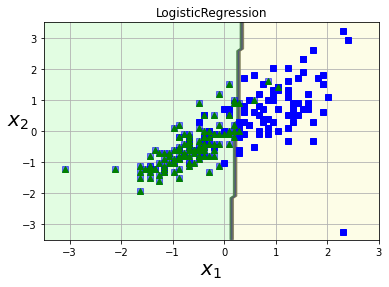

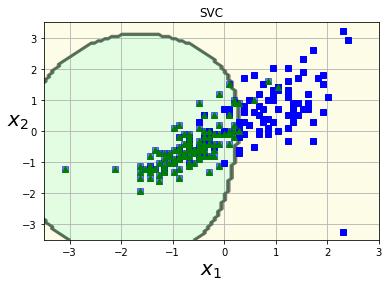

In [35]:
for clf in (lrM_clf, svm_clf_M):
    #plot_predictions(clf)
    plt.title(clf.__class__.__name__)
    plot_decision_boundary(clf,XM_train_1,yM1_train,axes=Axis_M)
    plot_dataset(XM_train_1,yM1_train,axes=Axis_M)
    plt.show()

Realizo la predicción para los datos de test en los hombres para cada clasificador y obtengo las matrices de confusión.

In [33]:
lrM_clf.fit(XM_test_1, yM1_test)
ylr_pred_M = lrM_clf.predict(XM_test_1)
CM_lr_M=confusion_matrix(yM1_test,ylr_pred_M)
print(CM_lr_M)

[[41  5]
 [ 6 40]]


In [34]:
svm_clf_M.fit(XM_test_1, yM1_test)
ysvm_pred_M = svm_clf_M.predict(XM_test_1)
CM_svm_M=confusion_matrix(yM1_test,ysvm_pred_M)
print(CM_svm_M)

[[41  5]
 [ 6 40]]


Realizando una predición para ambos clasificadores con las datos de testeo, y observando las matrices de confusión, se ve que clasificaron de la misma forma. Algo lógico ya que la mejoría del regresor por sobre el SVM no era muy significativa. 

**Ahora entreno los clasificadores para los grupos de mujeres.**

In [37]:
lrF_clf = RandomizedSearchCV(lr, parametros_lr, scoring= 'accuracy', cv=5, random_state=3) 
search_lrF = lrF_clf.fit(XF_train_1, yF1_train)
print('The parameters combination that would give best accuracy is : ')
print(lrF_clf.best_params_)
print('The best accuracy achieved after parameter tuning via grid search is : ', lrF_clf.best_score_)

The parameters combination that would give best accuracy is : 
{'C': 6.507979025745755, 'penalty': 'l1'}
The best accuracy achieved after parameter tuning via grid search is :  0.8591362126245847


In [38]:
lrF_clf = LogisticRegression(penalty = 'l1', C = 6.507, random_state=42, solver = 'saga', max_iter=200)

Acc_lrF = cross_val_score(lrF_clf, XF_train_1,yF1_train, scoring= 'accuracy',cv=5)
print('la media del accuracy es: ',Acc_lrF.mean()*100,'% +-',Acc_lrF.std()*100)

Pre_lrF = cross_val_score(lrF_clf, XF_train_1,yF1_train, scoring= 'precision',cv=5)
print('la media del precision es: ',Pre_lrF.mean()*100,'% +-',Pre_lrF.std()*100)

Rec_lrF = cross_val_score(lrF_clf, XF_train_1,yF1_train, scoring= 'recall',cv=5)
print('la media del recall es: ',Rec_lrF.mean()*100,'% +-', Rec_lrF.std()*100)

la media del accuracy es:  85.91362126245848 % +- 5.9647274667874886
la media del precision es:  85.59986450331279 % +- 6.460320653903276
la media del recall es:  93.07692307692307 % +- 6.153846153846154


In [39]:
lrF_clf.fit(XF_train_1, yF1_train)

LogisticRegression(C=6.507, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
svm_clf_F = RandomizedSearchCV (SVM, parametros_svm,
                             verbose=2,
                             n_iter=10, cv=5, random_state=3, scoring='accuracy')

search_svm_F = svm_clf_F.fit(XF_train_1, yF1_train)
print('The parameters combination that would give best accuracy is : ')
print(svm_clf_F.best_params_)
print('The best accuracy achieved after parameter tuning via grid search is : ', svm_clf_F.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=3.7539895128728773, gamma=0.16337053677214383 .................
[CV] .. C=3.7539895128728773, gamma=0.16337053677214383, total=   0.0s
[CV] C=3.7539895128728773, gamma=0.16337053677214383 .................
[CV] .. C=3.7539895128728773, gamma=0.16337053677214383, total=   0.0s
[CV] C=3.7539895128728773, gamma=0.16337053677214383 .................
[CV] .. C=3.7539895128728773, gamma=0.16337053677214383, total=   0.0s
[CV] C=3.7539895128728773, gamma=0.16337053677214383 .................
[CV] .. C=3.7539895128728773, gamma=0.16337053677214383, total=   0.0s
[CV] C=3.7539895128728773, gamma=0.16337053677214383 .................
[CV] .. C=3.7539895128728773, gamma=0.16337053677214383, total=   0.0s
[CV] C=2.4545236945647217, gamma=0.1424867339493832 ..................
[CV] ... C=2.4545236945647217, gamma=0.1424867339493832, total=   0.0s
[CV] C=2.4545236945647217, gamma=0.1424867339493832 ..................
[CV] ... C=2.454

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .. C=1.1199094118858268, gamma=0.14730986912934205, total=   0.0s
[CV] C=1.1199094118858268, gamma=0.14730986912934205 .................
[CV] .. C=1.1199094118858268, gamma=0.14730986912934205, total=   0.0s
[CV] C=1.1199094118858268, gamma=0.14730986912934205 .................
[CV] .. C=1.1199094118858268, gamma=0.14730986912934205, total=   0.0s
[CV] C=1.1199094118858268, gamma=0.14730986912934205 .................
[CV] .. C=1.1199094118858268, gamma=0.14730986912934205, total=   0.0s
[CV] C=1.1199094118858268, gamma=0.14730986912934205 .................
[CV] .. C=1.1199094118858268, gamma=0.14730986912934205, total=   0.0s
[CV] C=2.296262234537327, gamma=0.13333922038366894 ..................
[CV] ... C=2.296262234537327, gamma=0.13333922038366894, total=   0.0s
[CV] C=2.296262234537327, gamma=0.13333922038366894 ..................
[CV] ... C=2.296262234537327, gamma=0.13333922038366894, total=   0.0s
[CV] C=2.296262234537327, gamma=0.13333922038366894 ..................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished


In [41]:
svm_clf_F = svm.SVC( C= 1.627, kernel = 'rbf', gamma = 0.1154, probability=True, random_state= 3)

Acc_svm_F = cross_val_score(svm_clf_F, XF_train_1,yF1_train, scoring= 'accuracy',cv=5)
print('la media del accuracy es:',Acc_svm_F.mean()*100,'% +-',Acc_svm_F.std()*100)

Pre_svm_F = cross_val_score(svm_clf_F, XF_train_1,yM1_train, scoring= 'precision',cv=5)
print('la media del precision es:',Pre_svm_F.mean()*100,'% +-',Pre_svm_F.std()*100)

Rec_svm_F = cross_val_score(svm_clf_F, XF_train_1,yM1_train, scoring= 'recall',cv=5)
print('la media del recall es:',Rec_svm_F.mean()*100,'% +-',Rec_svm_F.std()*100)

la media del accuracy es: 84.98338870431894 % +- 6.112154279899458
la media del precision es: 59.15836101882614 % +- 0.9000808760228589
la media del recall es: 100.0 % +- 0.0


En este caso, haciendo una comparación con un cross validación, el regresor logístico presenta mejor Exactitud y Precisión que el SVM, pero el SVM tiene una exhaustividad del 100%. Este resutaldo resulta extraño tanto en la Precisión como la Exhaustividad del SVM.

In [43]:
svm_clf_F.fit(XF_train_1, yF1_train)

SVC(C=1.627, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1154, kernel='rbf',
    max_iter=-1, probability=True, random_state=3, shrinking=True, tol=0.001,
    verbose=False)

Veo la frontera de decisión para los datos de training en las mujeres para cada clasificador..

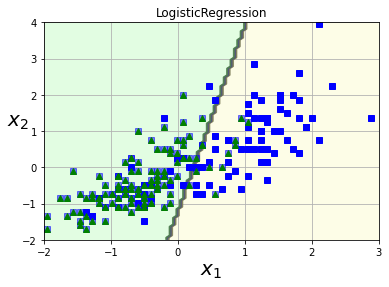

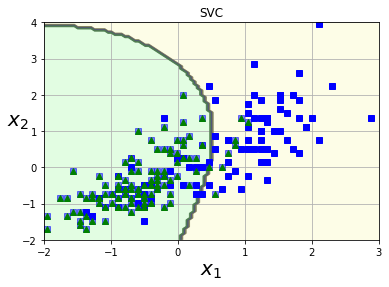

In [44]:
for clf in (lrF_clf, svm_clf_F):
    #plot_predictions(clf)
    plt.title(clf.__class__.__name__)
    plot_decision_boundary(clf,XF_train_1,yF1_train,axes=Axis_F)
    plot_dataset(XF_train_1,yF1_train,axes=Axis_F)
    plt.show()

In [45]:
lrF_clf.fit(XF_train_1, yF1_train)
ylr_pred_F = lrF_clf.predict(XF_train_1)
CM_lr_F=confusion_matrix(yF1_train,ylr_pred_F)
print(CM_lr_F)

[[ 64  20]
 [ 12 117]]


In [46]:
svm_clf_F.fit(XF_train_1, yF1_train)
ysvm_pred_F = svm_clf_F.predict(XF_train_1)
CM_svm_F=confusion_matrix(yF1_train,ysvm_pred_F)
print(CM_svm_F)

[[ 61  23]
 [  8 121]]


Analizando las matrices de confusión obtenidas con los datos de entrenamiento, se observa un valor de Exactitud y precisión distintos a los obtenidos para SVM por *cross validation*. 

Realizo la predicción para los datos de test en las mujeres para cada clasificador y obtengo las matrices de confusión.

In [48]:
lrF_clf.fit(XF_test_1, yF1_test)
ylr_pred_F = lrF_clf.predict(XF_test_1)
CM_lr_F=confusion_matrix(yF1_test,ylr_pred_F)
print(CM_lr_F)

[[27 10]
 [ 5 50]]


In [49]:
svm_clf_F.fit(XF_test_1, yF1_test)
ysvm_pred_F = svm_clf_F.predict(XF_test_1)
CM_svm_F=confusion_matrix(yF1_test,ysvm_pred_F)
print(CM_svm_F)

[[27 10]
 [ 2 53]]


Realizando una predición para ambos clasificadores con las datos de testeo, y observando las matrices de confusión, se ve que el SVM clasificó mejor los datos, aumentando los verdaderos positvos, disminuyendo los falsos negativos y por lo tanto, aumentando la precisión y la exhaustividad.